In [137]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


In [51]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 453, done.
remote: Total 453 (delta 0), reused 0 (delta 0), pack-reused 453
Receiving objects: 100% (453/453), 5.52 MiB | 33.43 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [138]:
from deep_learning_scratch.dataset import mnist

In [139]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self,x):
    out = 1/(1+np.exp(-x))
    self.out = out
    return out

  def backward(self,dout):
    dx = dout*(1-self.out)*self*out
    return dx


In [140]:
#Relu
class Relu:
  def __init__(self):
    self.mask = None
  def forward(self,x):
    self.mask = (x<=0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self,dout):
    dout[self.mask] = 0
    return dout  


In [141]:
class Affine:
  def __init__(self,w,b):
    self.w = w
    self.b = b
    self.db = None
    self.dw = None
    self.x = None

  def forward(self,x):
    self.x = x
    out = np.dot(x,self.w) + self.b
    return out

  def backward(self,dout):
    self.db = np.sum(dout,axis=0)
    self.dw = np.dot(self.x.T,dout)
    dx = np.dot(dout,self.w.T)
    return dx

In [142]:
def softmax(x):
  m = np.max(x,axis=1,keepdims = True)
  x -= m
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)


def cross_entropy_error(y,t):
  if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
  if t.size == y.size:
      t = t.argmax(axis=1)
             
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
  def __init__(self):
    self.y = None
    self.t = None
  def forward(self,x,t):
    y = softmax(x)
    self.y = y
    self.t = t
    return cross_entropy_error(y,t)

  def backward(self,dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y-self.t) / batch_size
    return dx
    

SGD部分をクラスに分けて実装

In [143]:
#最適化クラスの実装
class SGD:
  def __init__(self,learning_rate=0.01):
    self.lr= learning_rate

  def update(self,params,grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]


In [173]:
#クラスを用いたNNの実装
class FiveLayerNet:
  def __init__(self,input_size=784,hidden_size_list= [100,100,100], output_size = 10,weight_init_std=0.01):
    self.input_size = input_size
    self.hidden_size_list = hidden_size_list
    self.output_size = output_size
    self.layer_size_list = [input_size]+hidden_size_list+[output_size]
    self.layers_num = 1 + len(hidden_size_list)
    self.weight_init_std = weight_init_std
    if self.weight_init_std == 'Xavier':
      weight_init_std_list = [1/np.sqrt(self.layer_size_list[i]) for i in range(self.layers_num)]

    elif self.weight_init_std == 'He':
      weight_init_std_list = [np.sqrt(2/self.layer_size_list[i]) for i in range(self.layers_num)]

    else:
      weight_init_std_list = [weight_init_std for i in range(self.layers_num)]

    self.params = {}
    for i in range(self.layers_num):
      self.params['W'+str(i)] = weight_init_std_list[i]*np.random.randn(self.layer_size_list[i],self.layer_size_list[i+1])
      self.params['b'+str(i)] = np.zeros(self.layer_size_list[i+1])

    self.layers = OrderedDict()  
    for i in range(self.layers_num-1):
      self.layers['Affine'+str(i)] = Affine(self.params['W'+str(i)],self.params['b'+str(i)])
      self.layers['Relu'] = Relu()

    self.layers['Affine'+str(self.layers_num-1)] = Affine(self.params['W'+str(self.layers_num-1)],self.params['b'+str(self.layers_num-1)])

    self.lastlayer = SoftmaxWithLoss()


  def predict(self,x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return  x

  def loss(self,x,t):
    y = self.predict(x)
    l = self.lastlayer.forward(y,t)  

    return l

  def gradient(self):
    layers = list(self.layers.values())
    layers.reverse()

    dout = 1
    dout = self.lastlayer.backward(dout)
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}  
    for i in range(self.layers_num):
      grads['W'+str(i)] = self.layers['Affine'+str(i)].dw
      grads['b'+str(i)] = self.layers['Affine'+str(i)].db

    return grads

  def accuracy(self,x,t):
    y = self.predict(x)    
    y = np.argmax(y, axis=1)
    if t.ndim != 1:
      t = np.argmax(t, axis=1)
    accuracy = np.sum(y == t) / x.shape[0]
    return accuracy 






    
    

In [175]:
#学習と可視化
class Trainer:
  def __init__(self,network,x_train=x_train,t_train=t_train,train_size = 60000,batch_size=100,optimizer=SGD(learning_rate=0.01)):
    self.train_size = train_size
    self.batch_size = batch_size
    self.iters_per_epoch = train_size//batch_size
    self.network = network
    self.optimizer = optimizer
    self.data = {}
    (self.data['x_train'],self.data['t_train']) = x_train,t_train
    self.train_loss_list = None

    

  def train(self,epochs):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for epoch in range(epochs):
      for iter in range(self.iters_per_epoch):
        batch_mask = np.random.choice(self.train_size,self.batch_size)
        x_batch = self.data['x_train'][batch_mask]
        t_batch = self.data['t_train'][batch_mask]
    
        Loss = self.network.loss(x_batch,t_batch)
        grads = self.network.gradient()


        self.optimizer.update(self.network.params,grads)


        train_loss_list.append(Loss)
      
      print('=============='+'epoch'+str(epoch)+'================')
      print(f"{self.network.weight_init_std}:{Loss}")
      

    self.train_loss_list = train_loss_list  









様々な最適化手法の実装

In [146]:
#今回は、f(X,Y) = 1/20 × X^2 + Y^2 が最小となるパラメータを、最適化を用いて求めてみる。
def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y


In [148]:
#Momentum
class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None: #初めての学習の時はSGDと同じ
      self.v = {}
      for key, val in params.items():                                
        self.v[key] = np.zeros_like(val)
                
    for key in params.keys():
      self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
      params[key] += self.v[key]



In [149]:
#AdaGrad
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None
        
  def update(self, params, grads):
    if self.h is None: #初めての学習の時は
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)
            
    for key in params.keys():
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [150]:
#RMSprop
class RMSprop:
  def __init__(self, lr=0.01, decay_rate = 0.99):
    self.lr = lr
    self.decay_rate = decay_rate
    self.h = None
        
  def update(self, params, grads):
    if self.h is None:
      self.h = {}
    for key, val in params.items():
      self.h[key] = np.zeros_like(val)
            
    for key in params.keys():
      self.h[key] *= self.decay_rate
      self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [151]:
#Adam
class Adam:
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
  def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1 - self.beta1) * grads[key] 
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key]) #上の式を変形させただけ
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            

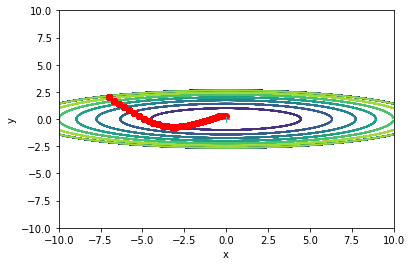

In [152]:
#各手法での学習過程
init_pos = (-7.0, 2.0) #x,y（パラメータ）の初期値
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

#optimizer = SGD(learning_rate=0.95)
#optimizer = Momentum(lr = 0.1)
#optimizer = AdaGrad(lr=1.5)
#optimizer = RMSprop(lr=)
optimizer = Adam(lr=0.3)


x_history = []
y_history = []

for i in range(30):
  x_history.append(params['x'])
  y_history.append(params['y'])
        
  grads['x'], grads['y'] = df(params['x'], params['y'])
  optimizer.update(params, grads)
    

  x = np.arange(-10, 10, 0.01)
  y = np.arange(-5, 5, 0.01)
    
  X, Y = np.meshgrid(x, y) 
  Z = f(X, Y)
    
  # for simple contour line  
  mask = Z > 7
  Z[mask] = 0
    
  # plot 

  plt.plot(x_history, y_history, 'o-', color="red")
  plt.contour(X, Y, Z)
  plt.ylim(-10, 10)
  plt.xlim(-10, 10)
  plt.plot(0, 0, '+')
  plt.xlabel("x")
  plt.ylabel("y")
    
plt.show()

アクティベーション分布と初期値

In [153]:
def ReLU(x):
  return np.maximum(0,x)

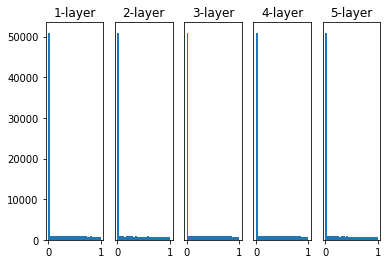

In [154]:
#今回は5層NN、初期・中間・出力ノードともに100個（つまり重みパラメータは100×100）におけるアクティベーションを観察する。
#初期値の標準偏差1
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    #z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


In [ ]:
#Heの初期値

MNISTデータセットによる初期値に依存した学習の比較

==============epoch0================
0.01:2.2997918111835562
==============epoch1================
0.01:2.3002560271215287
==============epoch2================
0.01:2.3022607176497236
==============epoch3================
0.01:2.299861545428808
==============epoch4================
0.01:2.3029753350738407
==============epoch5================
0.01:2.30148365718165
==============epoch6================
0.01:2.2844908058949556
==============epoch7================
0.01:2.3070408174596997
==============epoch8================
0.01:2.300765171698261
==============epoch9================
0.01:2.3103375557875676
==============epoch0================
Xavier:0.5332945360003477
==============epoch1================
Xavier:0.23274787391643023
==============epoch2================
Xavier:0.24826705226428306
==============epoch3================
Xavier:0.3147367871422056
==============epoch4================
Xavier:0.2646101159942846
==============epoch5================
Xavier:0.1880093441316694
==============

ValueError: ignored

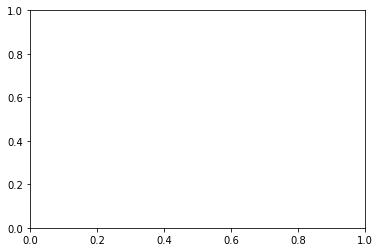

In [176]:
((x_train,t_train),(x_test,t_test)) = mnist.load_mnist(normalize=True,one_hot_label=True)


trainer_normal = Trainer(network=FiveLayerNet(weight_init_std=0.01))
trainer_xavier = Trainer(network=FiveLayerNet(weight_init_std='Xavier'))
trainer_he = Trainer(network=FiveLayerNet(weight_init_std='He'))

trainer_normal.train(epochs=10)
trainer_xavier.train(epochs=10)
trainer_he.train(epochs=10)



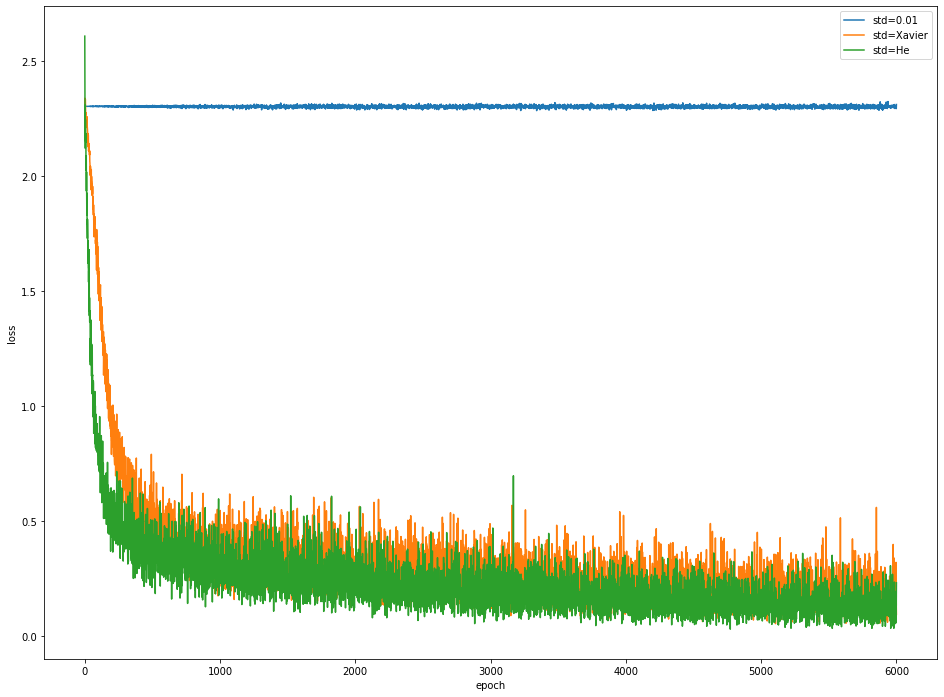

In [178]:
x = np.arange(1,6001)
fig, ax = plt.subplots(figsize=(16, 12))
#グラフを重ねるときに、軸によって指定する時にaxを使うらしい
#グラフの全体的なレイアウトをいじるときにfigを使う

plt.plot(x,trainer_normal.train_loss_list,label='std=0.01')
plt.plot(x,trainer_xavier.train_loss_list,label='std=Xavier')
plt.plot(x,trainer_he.train_loss_list,label='std=He')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

